In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import copy
from utils import *
from scipy import signal
from scipy.sparse import linalg
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import save_npz

In [69]:
def line_intersect(a1, a2, b1, b2):
    line1 = a2 - a1
    line2 = b2 - b1
    dab = a1 - b1
    dap = np.zeros(line1.shape)
    dap[0], dap[1] = -line1[1], line1[0]
    denom = np.dot(dap, line2)
    num = np.dot(dap, dab)
    return (num / denom)*line2 + b1

def define_coords(xs, ys, height, width, loc):
    if (loc == 0):
        # top left
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[0], abs(height - ys[0])])
        b1 = np.array([0,0])
        b2 = np.array([0,height])
    elif (loc == 1):
        # top right
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[2], abs(height - ys[0])])
        b1 = np.array([width,0])
        b2 = np.array([width,height])
    elif (loc == 2):
        # bottom left
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[0], abs(height - ys[2])])
        b1 = np.array([0,0])
        b2 = np.array([0,height])
    elif (loc == 3):
        # bottom right
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[2], abs(height - ys[2])])
        b1 = np.array([width,0])
        b2 = np.array([width,height])

    res = line_intersect(a1,a2,b1,b2)
    res[1] = height - res[1]
    return (int(res[0]), int(res[1]))

def display_box(coords, img):
    image = copy.deepcopy(img)
    xs, ys = [int(i) for i in coords[0]], [int(i) for i in coords[1]]
    coord1, coord2, coord3, coord4 = (xs[0],ys[0]), (xs[2],ys[0]), (xs[0],ys[2]), (xs[2],ys[2])
    color = (255, 0, 0) 
    thickness = 5
    cv2.line(image, coord1, coord2, color, thickness)
    cv2.line(image, coord2, coord4, color, thickness)
    cv2.line(image, coord4, coord3, color, thickness)
    cv2.line(image, coord3, coord1, color, thickness)
    
    height, width = image.shape[0], image.shape[1]
    
    top_left =  define_coords(xs, ys, height, width, 0)
    bottom_left = define_coords(xs, ys, height, width, 2)
    cv2.line(image, coord1, top_left, color, thickness)
    cv2.line(image, coord3, bottom_left, color, thickness)
    
    top_right =  define_coords(xs, ys, height, width, 1)
    bottom_right = define_coords(xs, ys, height, width, 3)
    cv2.line(image, coord2, top_right, color, 3)
    cv2.line(image, coord4, bottom_right, color, 3)
    
    plt.figure()
    plt.imshow(image)
    return image

def save_img(img, filename):
    image = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    plt.imsave(filename, img)

def makeCoords3D(xs, ys, x_multiplier, height, depth):
    P0 = ((xs[0]-xs[1])*x_multiplier, height, 0)
    P1 = ((xs[2]-xs[1])*x_multiplier, height, 0)
    P2 = ((xs[0]-xs[1])*x_multiplier, height, depth)
    P3 = ((xs[2]-xs[1])*x_multiplier, height, depth)
    P4 = ((xs[0]-xs[1])*x_multiplier, 0, depth)
    P5 = ((xs[2]-xs[1])*x_multiplier, 0, depth)
    P6 = ((xs[0]-xs[1])*x_multiplier, 0, 0)
    P7 = ((xs[2]-xs[1])*x_multiplier, 0, 0)
    return [P0,P1,P2,P3,P4,P5,P6,P7]

def getHomographyOfRightWall(img, xs, ys):
    height, width = img.shape[0], img.shape[1]
    
    # right coords
    a1 = np.array([xs[1], abs(h-ys[1])])
    a2 = np.array([xs[2], abs(h-ys[0])])
    b1 = np.array([width, 0])
    b2 = np.array([width, height])
    
    #pixel coordinate of P3, P5
    P00=np.array([ys[0],xs[2]])
    P10=np.array([ys[2],xs[2]])
    
    res = line_intersect(a1,a2,b1,b2)
    res[1] = height - res[1]
    #pixel coordinate of P1
    P01=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P5 --> P7 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P7
    P11=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def construct(coords, folder, img, focal_len):
    xs, ys = [int(i) for i in coords[0]], [int(i) for i in coords[1]]

    # back wall
    save_img(img[ys[0]:ys[2], xs[0]:xs[2]], folder+'/back.jpeg')
    
    #constants
    camera_height = 1
    camera_pos = (0,1,0)

    height = (ys[2]-ys[0]) / (ys[2]-ys[1])
    x_multiplier = 1 / (ys[2]-ys[1])
    depth = -focal_len / (ys[2]-ys[1])

    coords3D = makeCoords3D(xs, ys, x_multiplier, height, depth)
    
    return coords3D

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


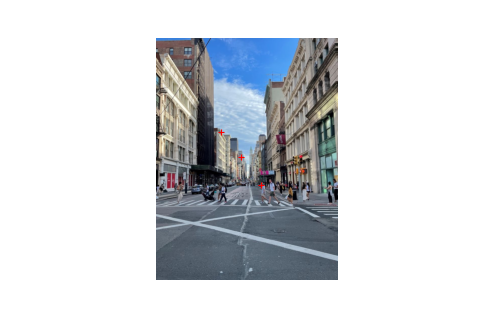

In [3]:
filename = 'images/1.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

import matplotlib.pyplot as plt
%matplotlib notebook
coords = specify_mask(img)

<IPython.core.display.Javascript object>


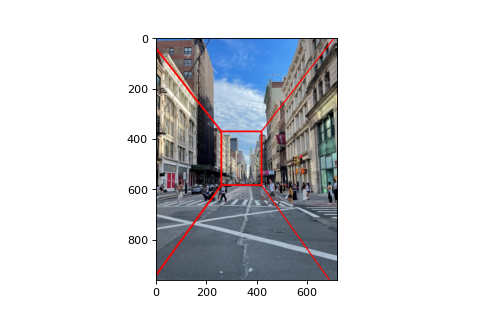

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [4]:
display = display_box(coords, img) #img does not change

In [70]:
construct(coords, 'images/1', img, 1000)

[(-0.7207207207207207, 1.9189189189189189, 0),
 (0.7117117117117117, 1.9189189189189189, 0),
 (-0.7207207207207207, 1.9189189189189189, -9.00900900900901),
 (0.7117117117117117, 1.9189189189189189, -9.00900900900901),
 (-0.7207207207207207, 0, -9.00900900900901),
 (0.7117117117117117, 0, -9.00900900900901),
 (-0.7207207207207207, 0, 0),
 (0.7117117117117117, 0, 0)]

In [11]:
img.shape

(960, 720, 3)